**1. Import**# 

In [1]:
import numpy as np, pandas as pd, os
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.metrics import make_scorer, cohen_kappa_score
from scipy.stats import uniform
import eli5
from optuna.samplers import TPESampler
import random
from eli5.sklearn import PermutationImportance
import warnings
warnings.simplefilter('ignore')

**2. Data**# 

In [2]:
path = '../input/child-mind-institute-problematic-internet-use/'

train = pd.read_csv(path + 'train.csv', index_col = 'id')
print("The train data has the shape: ",train.shape)
test = pd.read_csv(path + 'test.csv', index_col = 'id')
print("The test data has the shape: ",test.shape)
print("")
print("Total number of missing training values: ", train.isna().sum().sum())
data_dictionary = pd.read_csv(path + 'data_dictionary.csv')

The train data has the shape:  (3960, 81)
The test data has the shape:  (20, 58)

Total number of missing training values:  131717


In [3]:
SEED = 42  # Giá trị seed cố định

# Cố định seed cho random và NumPy
random.seed(SEED)
np.random.seed(SEED)

# Cố định seed cho Optuna
sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)

[I 2025-06-16 16:55:10,434] A new study created in memory with name: no-name-212b1eeb-b0d9-4b89-a081-92404ab931bc


**3. Predict Features**#

* **Demographics** - Information about age and sex of participants.
* **Internet Use** - Number of hours of using computer/internet per day.
* **Children's Global Assessment Scale** - Numeric scale used by mental health clinicians to rate the general functioning of youths under the age of 18.
* **Physical Measures** - Collection of blood pressure, heart rate, height, weight and waist, and hip measurements.
* **FitnessGram Vitals and Treadmill** - Measurements of cardiovascular fitness assessed using the NHANES treadmill protocol.
* **FitnessGram Child** - Health related physical fitness assessment measuring five different parameters including aerobic capacity, muscular strength, muscular endurance, flexibility, and body composition.
* **Bio-electric Impedance Analysis** - Measure of key body composition elements, including BMI, fat, muscle, and water content.
* **Physical Activity Questionnaire** - Information about children's participation in vigorous activities over the last 7 days.
* **Sleep Disturbance Scale** - Scale to categorize sleep disorders in children.
* **Actigraphy** - Objective measure of ecological physical activity through a research-grade biotracker. Many values seem to relate to a period *after* the PCIAT test was carried out.
* **Season** - for each set of measurements there is a 'season' feature which gives the season of the year when the measurements were carried out. These are the only predictive categorical features in the dataset and can be easily preprocessed.

In [4]:
train_cat_columns = train.select_dtypes(exclude = 'number').columns

for season in train_cat_columns:
    train[season] = train[season].fillna(0)
    train[season] = train[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

In [5]:
test_cat_columns = test.select_dtypes(exclude = 'number').columns

for season in test_cat_columns:
    test[season] = test[season].fillna(0)
    test[season] = test[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

**4. PCIAT**# 

* As mentioned there are 22 PCIAT features. These comprise answers to 20 questions (each marked out of 5), the total score and 'season' when the test was carried out.
* We will take a look at the questions and how they correlate with the total.
* The sii target is derived from the total PCIAT score:
    - 0-30 gives sii = 0
    - 31-49 gives sii = 1
    - 50-79 gives sii = 2
    - 80-100 gives sii = 3. 
* We show this by simply counting the values. The same information is confirmed [here](https://digitalwellnesslab.org/wp-content/uploads/Scoring-Overview.pdf).
* We drop all the PCIAT features from the dataset except the PCIAT Total feature which can be used as a regression target.
* The PCIAT Total visualisation box plot shows us that many of the top scores look like outliers - yet this is our most important category!

In [6]:
PCIAT_cols = [val for val in train.columns[train.columns.str.contains('PCIAT')]]
print('Number of PCIAT features = ' , len(PCIAT_cols))

Number of PCIAT features =  22


In [7]:
pd.set_option('display.max_colwidth', None)
questions = data_dictionary[data_dictionary.Field.str.contains('PCIAT-PCIAT')]
questions[['Field','Description']]

,Field,Description
55,PCIAT-PCIAT_01,How often does your child disobey time limits you set for online use?
56,PCIAT-PCIAT_02,How often does your child neglect household chores to spend more time online?
57,PCIAT-PCIAT_03,How often does your child prefer to spend time online rather than with the rest of your family?
58,PCIAT-PCIAT_04,How often does your child form new relationships with fellow online users?
59,PCIAT-PCIAT_05,How often do you complain about the amount of time your child spends online?
60,PCIAT-PCIAT_06,How often do your child's grades suffer because of the amount of time he or she spends online?
61,PCIAT-PCIAT_07,How often does your child check his or her e-mail before doing something else?
62,PCIAT-PCIAT_08,How often does your child seem withdrawn from others since discovering the Internet?
63,PCIAT-PCIAT_09,How often does your child become defensive or secretive when asked what he or she does online?
64,PCIAT-PCIAT_10,How often have you caught your child sneaking online against your wishes?


In [8]:
corr = train[PCIAT_cols].corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False)
corr = pd.DataFrame(corr)
corr.style.background_gradient(cmap='YlOrRd')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
PCIAT-PCIAT_05,0.830993
PCIAT-PCIAT_15,0.823996
PCIAT-PCIAT_17,0.823708
PCIAT-PCIAT_03,0.823336
PCIAT-PCIAT_18,0.802030
PCIAT-PCIAT_02,0.788802
PCIAT-PCIAT_13,0.771990
PCIAT-PCIAT_08,0.770499
PCIAT-PCIAT_16,0.769422


Text(0.5, 1.0, 'Boxplot of PCIAT Total Scores')

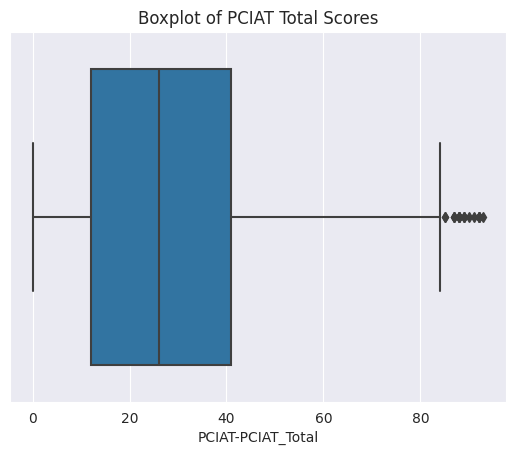

In [9]:
sns.boxplot(train, x = 'PCIAT-PCIAT_Total').set_title('Boxplot of PCIAT Total Scores')

In [10]:
print(train[train['PCIAT-PCIAT_Total']<=30].sii.value_counts())
print(train[(train['PCIAT-PCIAT_Total']>30) 
    & (train['PCIAT-PCIAT_Total']<50)].sii.value_counts())
print(train[(train['PCIAT-PCIAT_Total']>=50) 
    & (train['PCIAT-PCIAT_Total']<80)].sii.value_counts())
print(train[train['PCIAT-PCIAT_Total']>=80].sii.value_counts())

sii
0.0    1594
Name: count, dtype: int64
sii
1.0    730
Name: count, dtype: int64
sii
2.0    378
Name: count, dtype: int64
sii
3.0    34
Name: count, dtype: int64


In [11]:
PCIAT_cols.remove('PCIAT-PCIAT_Total')
train = train.drop(columns = PCIAT_cols)

**5. SII(Severity Impairment Index)**# 

* There was a reference to excessive internet usage amongst children and young people
* One of the puzzling things about the data is that, even for the 34 'severe' cases of PIU where sii =3, we can see that 5 participants assessed as severe are hardly using the internet at all.

Text(0.5, 1.0, 'Count of sii')

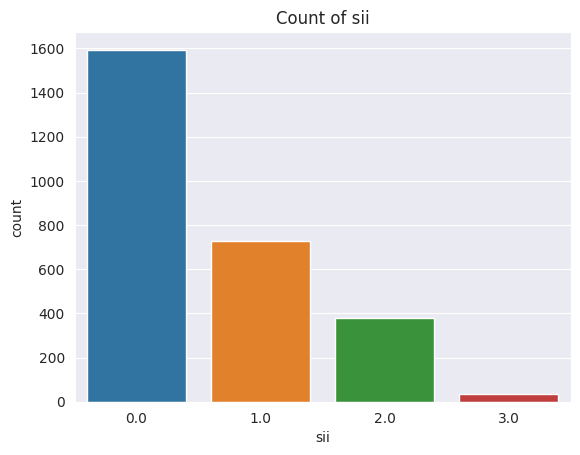

In [12]:
sns.countplot(train, x = 'sii').set_title('Count of sii')

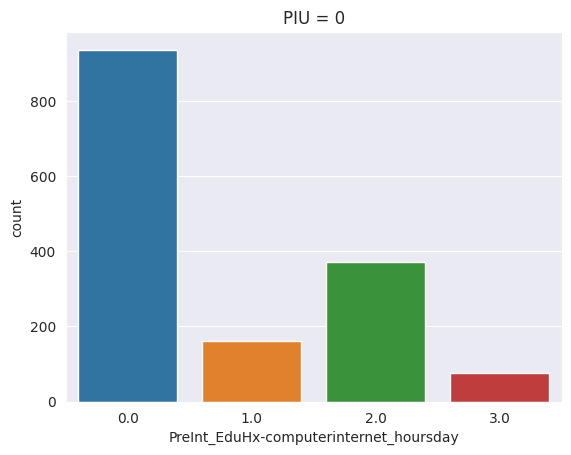

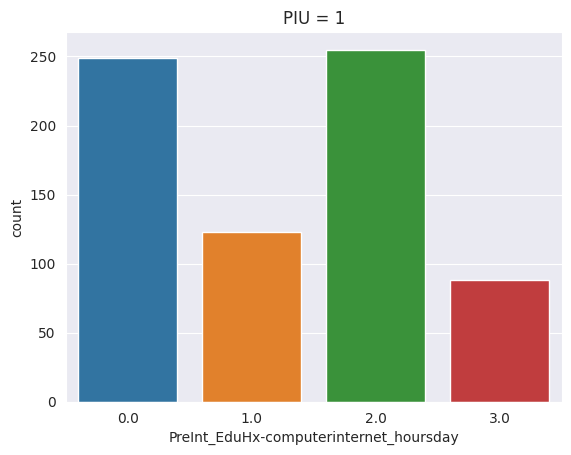

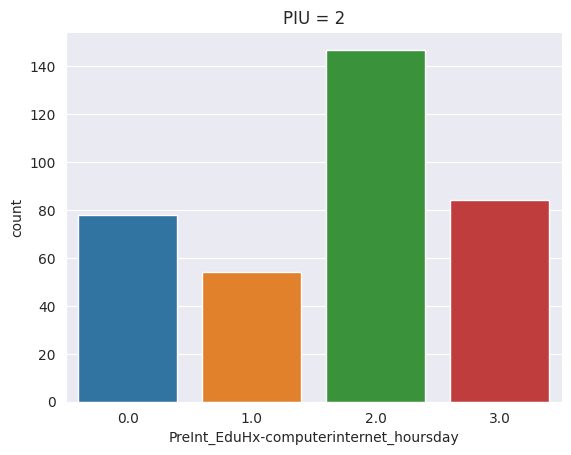

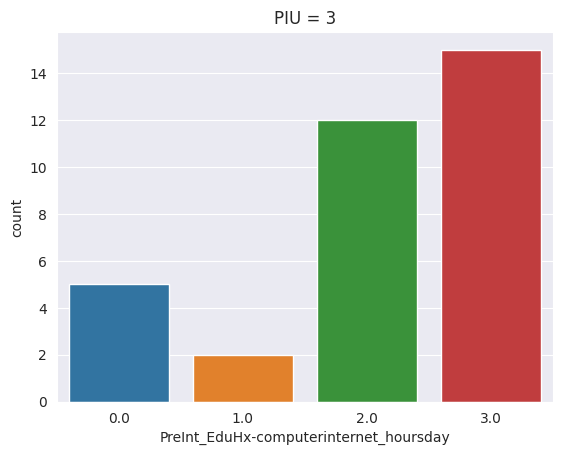

In [13]:
vals = ['PIU = 0', 'PIU = 1','PIU = 2', 'PIU = 3']

for i in range(4):
    plt.figure()
    plot = sns.countplot(x = train[train.sii==i]['PreInt_EduHx-computerinternet_hoursday'])
    plot.set_title(vals[i])

In [14]:
train = train.dropna(subset='sii')

**6. Correlations**# 

* With large numbers of features to choose from I decided to do some feature selection and check it's impact on the model.
* Here I select the features with the strongest correlation with the PCIAT total and drop the weaker ones.
* Two features, BMI and sleep disturbance, appear to be measured twice in the data with slighly different results.
* Clearly we don't need to keep both sets of features which will be closely correlated with each other even if not identical.
* Here I drop Physical-BMI an d SDS-SDS_Total_Raw which appear to have slightly lower correlations.

In [15]:
corr = pd.DataFrame(train.corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False))
corr.style.background_gradient(cmap='YlOrRd')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
Physical-Height,0.420765
Basic_Demos-Age,0.409559
PreInt_EduHx-computerinternet_hoursday,0.374124
Physical-Weight,0.353048
Physical-Waist_Circumference,0.327013
FGC-FGC_CU,0.287494
BIA-BIA_BMI,0.248060
Physical-BMI,0.240858


In [16]:
selection = corr[(corr['PCIAT-PCIAT_Total'].abs()> 0.1)]
selection = [val for val in selection.index]
selection.remove('PCIAT-PCIAT_Total')
selection.remove('sii')
selection.remove('Physical-BMI')
selection.remove('SDS-SDS_Total_Raw')

In [17]:
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

**7. Missing Values**# 

* There are large numbers of missing values remaining in the dataset, with 46 columns missing values and 8 columns missing more than half of their values.
* For example, most of the waist circumference feature values are missing.
* Let's drop columns where there are more than half values missing.
* Though we have not included the actigraphy data in this notebook analysis, these records are only available for just over a third of respondents.

In [18]:
null = train.isna().sum().sort_values(ascending = False).head(46)
null = pd.DataFrame(null)
null = null.rename(columns= {0:'Missing'})
null.style.background_gradient(cmap='YlOrRd')

,Missing
PAQ_A-PAQ_A_Total,2373
Physical-Waist_Circumference,2253
Fitness_Endurance-Time_Sec,2008
Fitness_Endurance-Time_Mins,2008
Fitness_Endurance-Max_Stage,2005
FGC-FGC_GSD_Zone,1872
FGC-FGC_GSND_Zone,1872
FGC-FGC_GSD,1865
FGC-FGC_GSND,1864
PAQ_C-PAQ_C_Total,1296


In [19]:
half_missing = [val for val in train.columns[train.isnull().sum()>len(train)/2]]
half_missing

['Physical-Waist_Circumference',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'PAQ_A-PAQ_A_Total']

In [20]:
selection = [i for i in selection if i not in half_missing]

**8. Selected Features**# 

* We now have 16 selected features based on a) correlation with the target and b) relatively few missing values.
* The idea is to create a robust model that focuses on key signals in the data and reduces some of the excess noise from large numbers of features.
* Some of the min and max values appear to be impossible (such as a minimum weight of zero) or very unlikely.

In [21]:
describe = train[selection].describe().T
describe = describe[['min','max']].sort_index()
describe.style.background_gradient(cmap='YlOrRd')

,min,max
BIA-BIA_BMI,0.048267,48.375400
BIA-BIA_FFMI,7.864850,217.771000
BIA-BIA_Frame_num,1.000000,3.000000
Basic_Demos-Age,5.000000,22.000000
FGC-FGC_CU,0.000000,115.000000
FGC-FGC_PU,0.000000,51.000000
FGC-FGC_SRL_Zone,0.000000,1.000000
FGC-FGC_SRR_Zone,0.000000,1.000000
FGC-FGC_TL,0.000000,21.000000
PAQ_A-Season,0.000000,4.000000


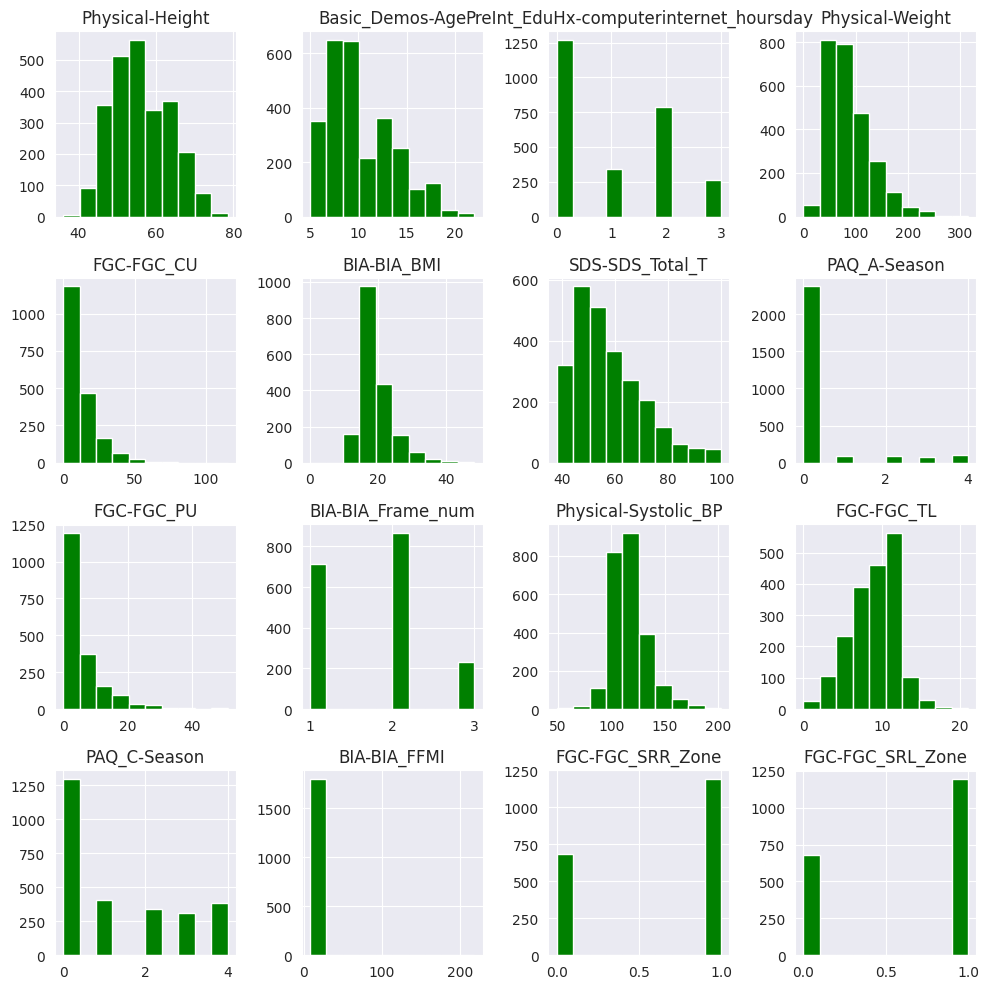

In [22]:
train[selection].hist(figsize=(10,10), grid = True, color = 'green')
plt.tight_layout()

**9. Regression Model**# 

* In this section I train an XGBoost regression model as a benchmark and use PCIAT-PCIAT_Total as the target.
* We tweak the quadratic kappa function to convert PCIAT total scores to sii categories, which gives a better cross-validation result.
* The model was tuned offline using Optuna to get the hyperparameters.
* I found that adding a scaling factor of 1.25 to the scores gives a better overall QWK score.
* The effect of this is to reduce the score thresholds from 30, 50, 80 to 24, 40, 64. It's quite possible there are even better values to be found.
* The final CV score is **.458**.

In [23]:
X = train[selection]
test = test[selection]
y = train['PCIAT-PCIAT_Total']

In [24]:
def convert(scores):
    scores = np.array(scores)*1.5
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins

In [25]:
def quadratic_kappa(y_true, y_pred):
    y_true_cat = convert(y_true)
    y_pred_cat = convert(y_pred)
    return cohen_kappa_score(y_true_cat, y_pred_cat, weights='quadratic')

kappa_scorer = make_scorer(quadratic_kappa, greater_is_better=True)

In [26]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'random_state': SEED,
    }
    model = xgb.XGBRegressor(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X, y, cv=skf, scoring=kappa_scorer)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

[I 2025-06-16 16:55:18,062] A new study created in memory with name: no-name-97a89884-0b28-463b-94c9-eec8314e7dec
[I 2025-06-16 16:55:22,730] Trial 0 finished with value: 0.40538941003340706 and parameters: {'max_depth': 10, 'n_estimators': 112, 'learning_rate': 0.0235325507750766, 'subsample': 0.9129305594394799, 'colsample_bytree': 0.7760391278610613}. Best is trial 0 with value: 0.40538941003340706.
[I 2025-06-16 16:55:24,409] Trial 1 finished with value: 0.42263325569304405 and parameters: {'max_depth': 8, 'n_estimators': 83, 'learning_rate': 0.08445843212480339, 'subsample': 0.7878045720929352, 'colsample_bytree': 0.8500397760320417}. Best is trial 1 with value: 0.42263325569304405.
[I 2025-06-16 16:55:26,777] Trial 2 finished with value: 0.3950059616829023 and parameters: {'max_depth': 9, 'n_estimators': 108, 'learning_rate': 0.08493862019324917, 'subsample': 0.6983615893446707, 'colsample_bytree': 0.731560941451512}. Best is trial 1 with value: 0.42263325569304405.
[I 2025-06-16

In [27]:
print("Best parameters found: ", best_params)

Best parameters found:  {'max_depth': 3, 'n_estimators': 176, 'learning_rate': 0.027049215364223476, 'subsample': 0.6203986299734814, 'colsample_bytree': 0.8486435968669341}


In [28]:
params = {'max_depth': 3, 'n_estimators': 87, 'learning_rate': 0.06306804675397865, 'subsample': 0.7886043382669142, 'colsample_bytree': 0.9957856093012589}
skf = StratifiedKFold(n_splits=10)

In [29]:
model = xgb.XGBRegressor(**params)

In [30]:
scores = cross_val_score(model, X, y, cv=skf, scoring=kappa_scorer)
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.41957086 0.48621507 0.58728068 0.46522578 0.47525858 0.45989066
 0.51923179 0.45147766 0.44851861 0.44643168]
Mean QWK Score: 0.4759101368416661


In [31]:
model.fit(X,y)
feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Basic_Demos-Age                           0.344452
PreInt_EduHx-computerinternet_hoursday    0.125975
SDS-SDS_Total_T                           0.072281
Physical-Height                           0.053967
Physical-Weight                           0.051058
FGC-FGC_CU                                0.049353
FGC-FGC_PU                                0.043878
PAQ_C-Season                              0.033835
BIA-BIA_Frame_num                         0.030965
PAQ_A-Season                              0.029934
FGC-FGC_SRL_Zone                          0.029845
FGC-FGC_TL                                0.029428
Physical-Systolic_BP                      0.029330
FGC-FGC_SRR_Zone                          0.027100
BIA-BIA_FFMI                              0.025053
BIA-BIA_BMI                               0.023546
dtype: float32

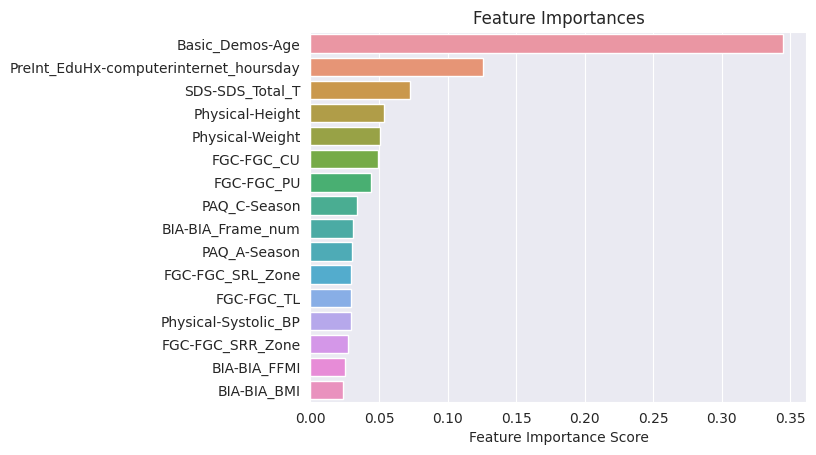

In [32]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.title("Feature Importances")
plt.show()

In [33]:
perm = PermutationImportance(model, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1207 ± 0.0119,PreInt_EduHx-computerinternet_hoursday
0.1167 ± 0.0117,SDS-SDS_Total_T
0.1018 ± 0.0084,Basic_Demos-Age
0.0266 ± 0.0034,Physical-Height
0.0259 ± 0.0028,Physical-Weight
0.0258 ± 0.0040,FGC-FGC_CU
0.0172 ± 0.0031,FGC-FGC_PU
0.0136 ± 0.0021,BIA-BIA_FFMI
0.0118 ± 0.0013,Physical-Systolic_BP
0.0095 ± 0.0021,FGC-FGC_SRL_Zone


**10. Submission**# 

In [34]:
model.fit(X,y)
preds = model.predict(test)
preds = convert(preds) # convert raw scores to sii categories if using regressor
preds = pd.Series(preds)
submission = pd.DataFrame({
    
    'id': test.index,  # Giả sử test.index chứa các ID
    'sii': preds
})
submission.to_csv('submission.csv', index=False)
submission

,id,sii
0,00008ff9,1.0
1,000fd460,0.0
2,00105258,1.0
3,00115b9f,1.0
4,0016bb22,1.0
5,001f3379,1.0
6,0038ba98,1.0
7,0068a485,1.0
8,0069fbed,2.0
9,0083e397,1.0
